/home/gaston/miniconda3/envs/gaston/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gaston/miniconda3/envs/gaston/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/gaston/miniconda3/envs/gaston/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/gaston/miniconda3/envs/gaston/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/gaston/miniconda3/envs/gaston/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Good LST


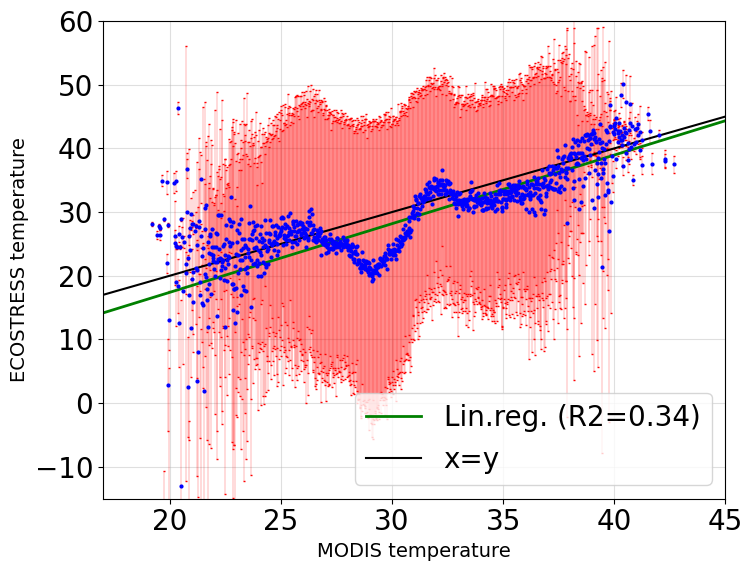

In [3]:
# concatenate them
import rasterio
import numpy as np
from rasterio.windows import Window
from affine import Affine
import matplotlib.pyplot as plt
from glob import glob
from os.path import join, basename, dirname
from scipy.stats import linregress
plt.rcParams.update({'font.size': 20})

d = {}

qf = "Good LST"
flags = [57346, 57359, 58050, 58054, 58304, 58306, 58309, 58310, 59074, 59078, 59328, 59329,
    59330, 59333, 59334, 60098, 60102, 60352, 60353, 60354, 60357, 60358, 61122, 61126,
    61376, 61378, 61381, 61382]
d = {}
for ecostress_lst_file in glob("/data/gaston/ecostress/ECOSTRESS_data/ECO*LST.tif"):
    modis_file = join(dirname(ecostress_lst_file), "MODIS_" + '_'.join(basename(ecostress_lst_file).split('_')[-4:]))
    with rasterio.open(modis_file) as coarse_src:
        coarse_data = coarse_src.read(1)
        coarse_transform = coarse_src.transform
        coarse_res = (coarse_transform[0], -coarse_transform[4])

    fine_src = rasterio.open(ecostress_lst_file)
    fine_data = fine_src.read(1)
    fine_transform = fine_src.transform
    fine_res = (fine_transform[0], -fine_transform[4])

    qc_band_path = ecostress_lst_file.replace("LST.", "QC.")
    qc_src = rasterio.open(qc_band_path)
        
    coarse_fine_map = {}

    for i in range(coarse_data.shape[0]):  # Rows
        for j in range(coarse_data.shape[1]):  # Columns
            if coarse_data[i,j] == 0:
                continue
            minx, miny = coarse_transform * (j, i)
            maxx, maxy = coarse_transform * (j + 1, i + 1)
            minx = np.max([minx, fine_src.bounds[0]])
            miny = np.max([miny, fine_src.bounds[1]])
            maxx = np.min([maxx, fine_src.bounds[2]])
            maxy = np.min([maxy, fine_src.bounds[3]])
            fine_window = fine_src.window(minx, maxy, maxx, miny)
            fine_window = fine_window.round_offsets(op='floor').round_lengths(op='ceil')
            fine_subset = fine_src.read(1, window=fine_window)
            fine_subset_qc = qc_src.read(1, window=fine_window)
            subdata = fine_subset.flatten()
            subdata_qc = fine_subset_qc.flatten()
            if qf != 'No quality flag':
                mask = np.isin(subdata_qc, flags)
                subdata = subdata[~mask]
            subdata = subdata[np.where(subdata!=-273.15)]
            coarse_fine_map[(i, j)] = subdata

    
    for i,j in coarse_fine_map.items():
        if coarse_data[i] != 0:
            if not coarse_data[i] in d:
                d[coarse_data[i]] = np.array([])
            d[coarse_data[i]] = np.concatenate([d[coarse_data[i]], j])

means = {key: np.mean(values) for key, values in d.items()}
stds = {key: np.std(values) for key, values in d.items()}

keys = list(means.keys())
mean_values = list(means.values())
std_values = list(stds.values())

plt.figure(figsize=(8, 6))
plt.errorbar(keys, mean_values, yerr=std_values, fmt='o', color='blue', ecolor='red', elinewidth=0.2, capsize=1, markersize=2)
keys, mean_values = np.asarray(keys), np.asarray(mean_values)
mask = ~np.isnan(keys) & ~np.isnan(mean_values) 
keys_clean = keys[mask]
mean_values_clean = mean_values[mask]

slope, intercept, r_value, p_value, std_err = linregress(keys_clean, mean_values_clean)
x_min, x_max = keys.min(), keys.max()
x_range_extension = (x_max - x_min) * 0.1  # Extend by 10%
extended_keys = np.linspace(x_min, x_max + x_range_extension, 100)
plt.plot(extended_keys, intercept + slope * extended_keys, 'g-', linewidth=2, alpha=1, label=f"Lin.reg. (R2={r_value**2:.2f})")

begin = 17
end = 45
plt.plot(np.arange(begin,end+5), np.arange(begin,end+5), color='black', label='x=y')
plt.xlabel('MODIS temperature', fontsize=14)
plt.ylabel('ECOSTRESS temperature', fontsize=14)
print(qf)
plt.tight_layout()

plt.ylim(-15,60)
plt.xlim(begin,end)
plt.grid(alpha=0.4)
plt.legend()
plt.savefig(f"../../../figures/Appendix/comparison_modis_ecostress.png", bbox_inches='tight')
plt.show()
